# Predicting the Number of High PM2.5 Levels for Cities in China

# Table of Contents:
1. [Summary of Notebook](#summary)
2. [Environment Setup](#envsetup)
3. [Data Loading](#loading)
4. [Create Label](#label)
5. [Data Concatenation](#data_concat)
6. [Onehot Encode Months and Cities](#onehot)
7. [Data Split](#data_split)
8. [Models](#models)
    1. [Ridge Regression](#ridge)
    2. [Neural Network](#nn)
    3. [CatBoost](#catboost)
9. [Metrics Used](#metrics)
10. [Results](#results)
11. [Future Work](#future)


## Summary of Notebook<a id='summary'></a>

**Project Background**: PM2.5 stands for particular matter; tiny particles in the air usually with diameters around 2.5 micrometers or smaller. They can affect the respiratory and cardiovascular systems, and is associated with multiple diseases such as lung cancer and chronic bronchitis. It also can worsen the symptoms of patients with respiratory allergies. Sources of PM2.5 are: vehicles exhausts, burning fuels operations, power plants, and natural causes such as forest fires and volcanos. 

**Project Goal**: Five datasets for five cities in China are given: Beijing, Chengdu, Guangzhou, Shanghai, Shenyang. In each dataset there is the hourly PM levels reported by $3$ or $4$ stations, and other meteorological measurements such as temperature, pressure, etc. The goal is to predict the number of days that are high for PM2.5 levels averaged over the course of each calendar month for each city from the datasets that we currently have.

**Methods**: Dataset contains five datasets for five cities in China. Outliers were removed. Feature engineeing was performed by averaging the hours and different stations to a daily value. Train set was chosen from $2010$ till $2014$, and test set is $2015$. A PM level of 55 or larger is considered large in this analysis. The label was created by counting the number of days that have a PM level equal or greater than 55 for the next 30 days. The prediction is generated from multiple features at one timestamp.

## Environment Setup<a id='envsetup'></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import sys
import os
import math
import copy
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np

List of directories

In [3]:
DIRECTORY_DATA = '../data/external/'

DIRECTORY_INTER = '../data/inter/'

In [4]:
if '../src' not in sys.path:
    sys.path.append('../src')
    
import utils

Global variables

In [5]:
CITY_DICT_NO_NA_FILENAME = "city_dict_no_na.pkl"

RIDGE_MODEL_FILENAME = "ridge_model.pkl"
RIDGE_SCORES_FILENAME = "ridge_scores.pkl"

NN_MODEL_FILENAME = "nn_model.h5"
NN_SCORES_FILENAME = "nn_scores.pkl"

CATBOOST_MODEL_FILENAME = "catboost_model.pkl"
CATBOOST_SCORES_FILENAME = "catboost_scores.pkl"

RIDGE_RANDOM_SEED = 43

NN_RANDOM_SEED = 43

CATBOOST_RANDOM_SEED = 43

WINDOW = 30

PM_HIGH = 55

TEST_YEAR = 2015

## Data Loading<a id='loading'></a>

In [6]:
with open(os.path.join(DIRECTORY_INTER,CITY_DICT_NO_NA_FILENAME), 'rb') as handle:
    city_dict = pickle.load(handle)

## Create Label<a id='label'></a>

Create a new col called `count_greater_than_PM_high`, which counts the number of PM_avg days that are greater than PM_high for the next $30$ days

In [7]:
for city, df in city_dict.items():
    df['greater_than_PM_high'] = df['PM_avg'] >= PM_HIGH
    df['count_greater_than_PM_high'] = df['greater_than_PM_high'].shift(-1).rolling(WINDOW).sum().shift(-WINDOW+1)
    df.dropna(axis=0, how='any',inplace=True)

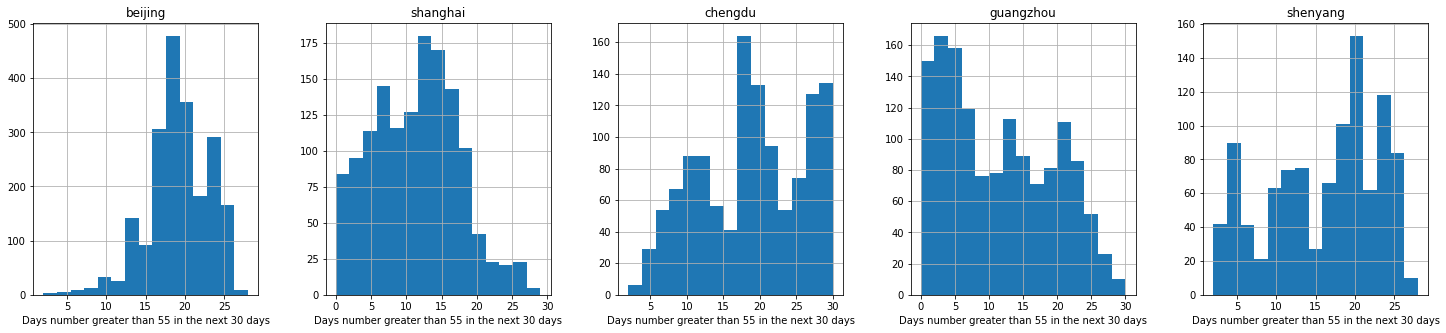

In [8]:
ax = fig, ax = plt.subplots(1,5,figsize=(25, 5))
city_index = 0
for city, df in city_dict.items():
    df.hist(column=['count_greater_than_PM_high'],bins=15,figsize=(5,5),ax=ax[city_index])
    ax[city_index].set_title(city)
    ax[city_index].set_xlabel('Days number greater than 55 in the next 30 days')
    city_index += 1
    
plt.show()

## Data Concatenation<a id='data_concat'></a>

The datasets for all cities are concatenated vertically with the name of the city added in a new column called `city`

In [9]:
for city, df in city_dict.items():
    df['city'] = city

In [10]:
df = pd.concat([df_city for city,df_city in city_dict.items()], ignore_index=True)

## Onehot Encode Months and Cities <a id='onehot'></a>

In [11]:
df_onehot = df.copy()

In [12]:
df_onehot = utils.onehot_encode(df_onehot,'month')
df_onehot = utils.onehot_encode(df_onehot,'city')
df_onehot.rename(columns={1: 'January', 
                          2: 'February', 
                          3: 'March', 
                          4: 'April',
                          5: 'May',
                          6: 'June',
                          7: 'July',
                          8: 'August',
                          9: 'Septmeber',
                          10: 'October',
                          11: 'November',
                          12: 'December'}, inplace=True)

## Data Split<a id='data_split'></a>

In [13]:
train = df_onehot[df_onehot['year'] != TEST_YEAR]
test = df_onehot[df_onehot['year'] == TEST_YEAR]

Some machine learning algorithms require to onehot encode categorical variables such as linear regression and neural network, and some such as Catboost don't. Hence, we have two types of $X$ and $y$.

In [14]:
X_train = train[['DEWP','HUMI','PRES','TEMP','Iws','precipitation','Iprec','PM_avg','month','city']]
y_train = train[['count_greater_than_PM_high']]

X_test = test[['DEWP','HUMI','PRES','TEMP','Iws','precipitation','Iprec','PM_avg','month','city']]
y_test = test[['count_greater_than_PM_high']]

In [15]:
X_train_onehot = train[['DEWP','HUMI','PRES','TEMP','Iws','precipitation','Iprec','PM_avg',
                        'January','February','March','April','May','June','July','August',
                        'Septmeber','October','November','December', 'beijing', 'chengdu', 
                        'guangzhou', 'shanghai','shenyang']]
y_train_onehot = train[['count_greater_than_PM_high']]

X_test_onehot = test[['DEWP','HUMI','PRES','TEMP','Iws','precipitation','Iprec','PM_avg',
                      'January','February','March','April','May','June','July','August',
                      'Septmeber','October','November','December', 'beijing', 'chengdu', 
                      'guangzhou', 'shanghai','shenyang']]
y_test_onehot = test[['count_greater_than_PM_high']]

## Models<a id='models'></a>

### Ridge Regression<a id='ridge'></a>

In [16]:
ridge_params = {
    'random_state': [RIDGE_RANDOM_SEED],
    'alpha': [0.001,0.01,0.1,1,10,100]
}

In [17]:
ridge_reg, ridge_reg_scores = utils.ridge(ridge_params,DIRECTORY_INTER,RIDGE_MODEL_FILENAME,RIDGE_SCORES_FILENAME,X_train_onehot,y_train_onehot)

In [18]:
utils.display_results(ridge_reg_scores,"Ridge Regression")

Cross Validation MSE for Ridge Regression

Scores:  [46.39225394 18.02569092 32.74036117 43.37880678 23.80465188]
Average MSE:  32.86835293634422
Average RMSE:  5.733092789790186


### Neural Network<a id='nn'></a>

In [19]:
nn_params = {
    'hidden_sizes':[(128,64), (256,128), (64,32)],
    'batch':[32,64,128,256],
    'dropout_rate':[0.0,0.1,0.2,0.3],
    'random_state': [NN_RANDOM_SEED]
}

In [20]:
nn_reg , nn_reg_scores = utils.neural(nn_params,DIRECTORY_INTER,NN_SCORES_FILENAME,NN_MODEL_FILENAME,X_train_onehot,y_train_onehot)

2021-12-31 23:49:09.013754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
utils.display_results(nn_reg_scores,"Neural Network Regression")

Cross Validation MSE for Neural Network Regression

Scores:  [38.53504596 28.20409295 45.93588993 44.90000059 22.33496366]
Average MSE:  35.98199861799593
Average RMSE:  5.998499697257301


### CatBoost<a id='catboost'></a>

In [22]:
catboost_params = {
    'depth':[2, 6, 8, 10], 
    'iterations':[25,100,500],
    'learning_rate':[0.01,0.1]
}

cat_features = ['month', 'city']
num_features = ['DEWP','HUMI','PRES','TEMP','Iws','precipitation','Iprec','PM_avg']

In [25]:
catboost_reg , catboost_reg_scores = utils.catboost(catboost_params, cat_features,num_features,DIRECTORY_INTER,
                                                    CATBOOST_MODEL_FILENAME,CATBOOST_SCORES_FILENAME,X_train,y_train)

247:	learn: 1.3683483	total: 12.8s	remaining: 13.1s
248:	learn: 1.3673338	total: 12.9s	remaining: 13s
249:	learn: 1.3645971	total: 12.9s	remaining: 12.9s
250:	learn: 1.3592866	total: 13s	remaining: 12.9s
251:	learn: 1.3576489	total: 13s	remaining: 12.8s
252:	learn: 1.3550593	total: 13s	remaining: 12.7s
253:	learn: 1.3531419	total: 13.1s	remaining: 12.7s
254:	learn: 1.3520064	total: 13.1s	remaining: 12.6s
255:	learn: 1.3514016	total: 13.2s	remaining: 12.5s
256:	learn: 1.3484216	total: 13.2s	remaining: 12.5s
257:	learn: 1.3453761	total: 13.3s	remaining: 12.4s
258:	learn: 1.3445163	total: 13.3s	remaining: 12.4s
259:	learn: 1.3416889	total: 13.3s	remaining: 12.3s
260:	learn: 1.3398210	total: 13.4s	remaining: 12.2s
261:	learn: 1.3367377	total: 13.4s	remaining: 12.2s
262:	learn: 1.3354828	total: 13.4s	remaining: 12.1s
263:	learn: 1.3344858	total: 13.5s	remaining: 12s
264:	learn: 1.3337588	total: 13.5s	remaining: 12s
265:	learn: 1.3316910	total: 13.6s	remaining: 11.9s
266:	learn: 1.3310052	to

In [26]:
utils.display_results(catboost_reg_scores,"Catboost Regression")

Cross Validation MSE for Catboost Regression

Scores:  [23.04241305  8.70315884 31.18439518 44.66502269 16.49691236]
Average MSE:  24.818380424099185
Average RMSE:  4.98180493637589


## Metrics Used<a id='metrics'></a>

<ol>
    <li> Mean Squared Error (MSE) $$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_{i}-\hat{Y}_{i})^{2}$$</li>
    <li> Root Mean Squared Error (RMSE) $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(Y_{i}-\hat{Y}_{i})^{2}}$$</li>
</ol>

## Results<a id='results'></a>

In [27]:
ridge_reg_predictions, ridge_reg_results = utils.predict_evaluate(ridge_reg, X_test_onehot, y_test_onehot,"Ridge Regression")
nn_reg_predictions, nn_reg_results = utils.predict_evaluate(nn_reg, X_test_onehot,y_test_onehot,"Neural Network")
catboost_reg_predictions, catboost_reg_results = utils.predict_evaluate(catboost_reg, X_test,y_test,"CatBoost")

Test data evaulation for Ridge Regression

MSE:  40.532375619877115 
RMSE:  6.36650419145995
---------------------------------

Test data evaulation for Neural Network

MSE:  46.71276478221727 
RMSE:  6.834673714393195
---------------------------------

Test data evaulation for CatBoost

MSE:  32.74859712446607 
RMSE:  5.722639000012675
---------------------------------



In [28]:
test_results = [ridge_reg_results, nn_reg_results, catboost_reg_results]

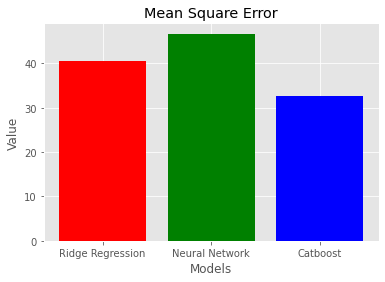

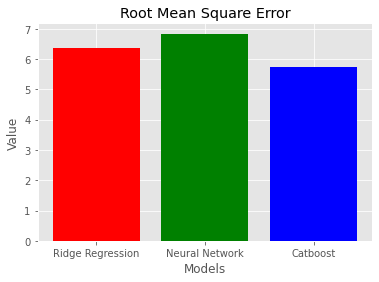

In [29]:
utils.plot_result(title='Mean Square Error', results=test_results, metrics_index=0)
utils.plot_result(title='Root Mean Square Error', results=test_results, metrics_index=1)

In [30]:
ridge_reg_df = pd.concat([X_test_onehot.reset_index(drop=True), 
                          pd.DataFrame(ridge_reg_predictions,columns=['predictions']).reset_index(drop=True), 
                          y_test_onehot.reset_index(drop=True)],axis=1)
nn_reg_df = pd.concat([X_test_onehot.reset_index(drop=True), 
                       pd.DataFrame(nn_reg_predictions,columns=['predictions']).reset_index(drop=True), 
                       y_test_onehot.reset_index(drop=True)],axis=1)
catboost_reg_df = pd.concat([X_test.reset_index(drop=True), 
                             pd.DataFrame(catboost_reg_predictions,columns=['predictions']).reset_index(drop=True), 
                             y_test.reset_index(drop=True)],axis=1)

In [31]:
cities = list(city_dict.keys())

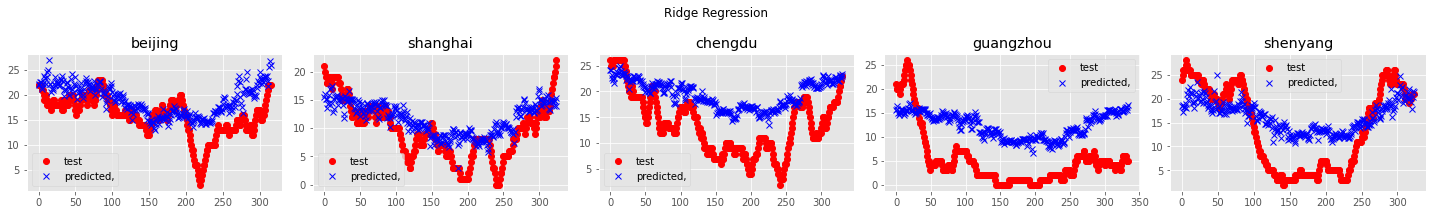

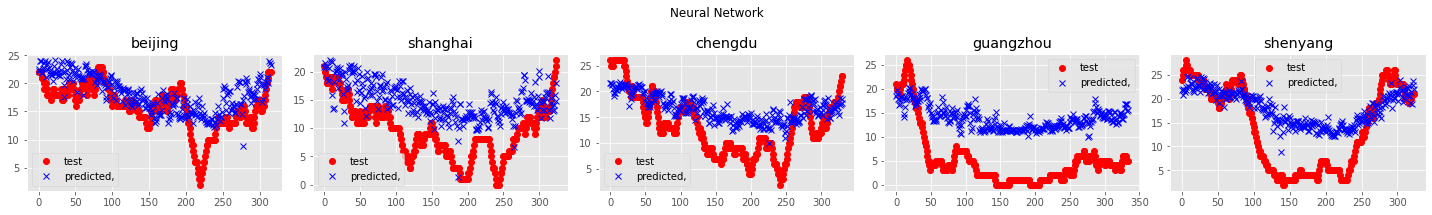

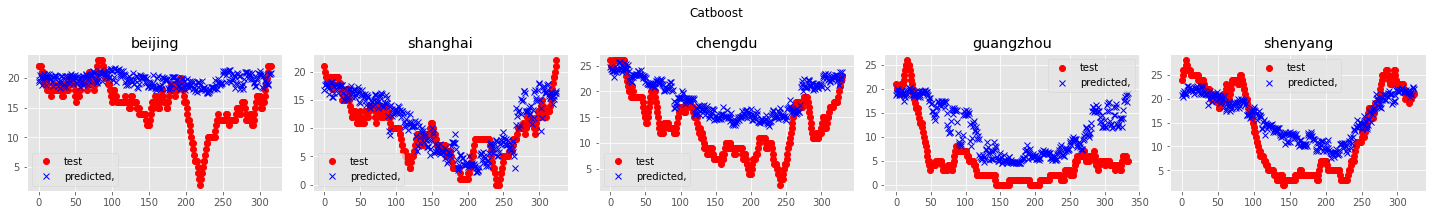

In [32]:
plt.style.use('ggplot')
utils.plot_test_and_predicted(ridge_reg_df,"Ridge Regression",cities)
utils.plot_test_and_predicted(nn_reg_df,"Neural Network",cities)
utils.plot_test_and_predicted(catboost_reg_df,"Catboost",cities)

The y axis for all plots above denotes the number of days that have PM level equal to greater than $55$ for the next $30$ days.

In [33]:
y_test_monthly = y_test.iloc[::WINDOW, :]

In [34]:
ridge_monthly_pred = ridge_reg_predictions[::WINDOW]
nn_monthly_pred = nn_reg_predictions[::WINDOW]
catboost_monthly_pred = catboost_reg_predictions[::WINDOW]

In [35]:
ridge_monthly_results = utils.rmse_mae_monthly(y_test_monthly,ridge_monthly_pred,"Ridge Regression")
nn_monthly_results = utils.rmse_mae_monthly(y_test_monthly,nn_monthly_pred,"Neural Network")
catboost_monthly_results = utils.rmse_mae_monthly(y_test_monthly,catboost_monthly_pred,"CatBoost")

Test data evaulation for Ridge Regression

MSE:  41.81247667945556 
RMSE:  6.466256774939854
---------------------------------

Test data evaulation for Neural Network

MSE:  46.24740177148079 
RMSE:  6.800544226124906
---------------------------------

Test data evaulation for CatBoost

MSE:  33.41149978880492 
RMSE:  5.780268141600779
---------------------------------



In [36]:
monthly_test_results = [ridge_monthly_results, nn_monthly_results, catboost_monthly_results]

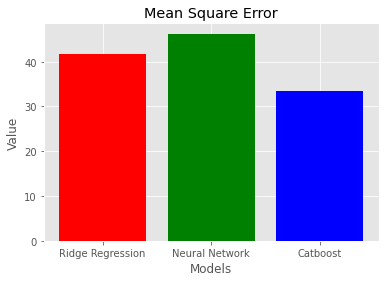

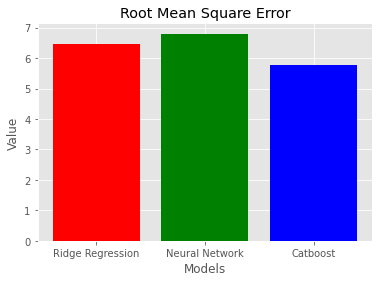

114:	learn: 2.7187855	total: 8.74s	remaining: 29.3s
115:	learn: 2.7098339	total: 8.8s	remaining: 29.1s
116:	learn: 2.7014634	total: 8.88s	remaining: 29.1s
117:	learn: 2.6964714	total: 8.94s	remaining: 28.9s
118:	learn: 2.6886530	total: 9.03s	remaining: 28.9s
119:	learn: 2.6847368	total: 9.1s	remaining: 28.8s
120:	learn: 2.6804769	total: 9.19s	remaining: 28.8s
121:	learn: 2.6734578	total: 9.26s	remaining: 28.7s
122:	learn: 2.6671440	total: 9.34s	remaining: 28.6s
123:	learn: 2.6624362	total: 9.4s	remaining: 28.5s
124:	learn: 2.6571284	total: 9.47s	remaining: 28.4s
125:	learn: 2.6521854	total: 9.53s	remaining: 28.3s
126:	learn: 2.6448326	total: 9.63s	remaining: 28.3s
127:	learn: 2.6426575	total: 9.71s	remaining: 28.2s
128:	learn: 2.6371646	total: 9.8s	remaining: 28.2s
129:	learn: 2.6338921	total: 9.88s	remaining: 28.1s
130:	learn: 2.6315872	total: 9.95s	remaining: 28s
131:	learn: 2.6255486	total: 10s	remaining: 27.9s
132:	learn: 2.6197260	total: 10.1s	remaining: 27.8s
133:	learn: 2.615661

In [37]:
utils.plot_result(title='Mean Square Error', results=monthly_test_results, metrics_index=0)
utils.plot_result(title='Root Mean Square Error', results=monthly_test_results, metrics_index=1)

Catboost model has the best results overall in terms of RMSE and MAE metrics.

Text(0.5, 0, 'CatBoost Feature Importance')

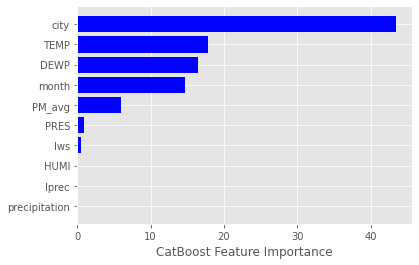

In [42]:
sorted_feature_importance = catboost_reg.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        catboost_reg.feature_importances_[sorted_feature_importance], 
        color='blue')
plt.xlabel("CatBoost Feature Importance")

City, temperature, dew point, month, and PM_avg were the most important features for Catboost model to make its predictions.

## Future Work<a id='future'></a>


<p> Some possible ways to improve the current model or building other models are: </p>
<ol>
    <li> We can predict the number of days that have high PM levels for the first month, January for example, with the existing model. Then, before February starts, we can include the January true labels in the dataset labels (since January days have been observed), and train the model again, given the new data from January to predict the number of days that have high PM levels for February. </li>
    <li> We can work with the hourly dataset (without averaging the hours) and without averaging the stations, and try to predict the PM levels at each hour for each station for the next month, and then we average the hours and stations after the prediction and perform some calculations to obtain the number of days that have high PM levels for the next month. This model is a less coarse-grained model than what we currently have.</li>
    <li> Use measurements from previous timestamps in order to improve prediction performance instead of just relying on one timestamp measurements. This will involve more data preprocessing, dimensionality reduction algorithms, and more hyperparameters.
</ol>